<a href="https://colab.research.google.com/github/mel418/CECS456_Melody_VGG16/blob/main/VGG16_Animals10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 for Animals10 Classification

**CECS 456 - Deep Learning Project**

Melody Gatan

**Dataset:** Animals10 (10 animal categories)

**Model:** VGG16

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import os
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


## 2. Mount Google Drive and Setup Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to project folder
%cd '/content/drive/MyDrive/CECS456_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CECS456_Project


## 4. Custom Dataset Class

In [3]:
class Animals10Dataset(Dataset):
    """Custom dataset class for Animals10."""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get class names from folder names
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        print(f"Found classes: {self.classes}")

        # Load all image paths and labels
        for idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(idx)

        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image if error occurs
            return torch.zeros(3, 128, 128), label

print("Dataset class defined!")

Dataset class defined!


In [4]:
class VGG16FromScratch(nn.Module):
    """VGG16 architecture trained from random initialization."""

    def __init__(self, num_classes=10):
        super(VGG16FromScratch, self).__init__()

        # VGG16 Feature Extraction Layers
        # All layers will be trained from scratch (no pretrained weights)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # BatchNorm helps with scratch training
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),  # 128x128 input -> 4x4 after pooling
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

        # Initialize all weights from scratch
        self._initialize_weights()

    def _initialize_weights(self):
        """Kaiming initialization for better training from scratch."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

print("VGG16FromScratch model defined!")

VGG16FromScratch model defined!


## 5. Data Transformations and Augmentation

In [5]:
IMG_SIZE = 128

# Training transformations (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transformations (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transformations defined!")

Data transformations defined!


## 6. Load and Split Dataset

In [6]:
# Dataset path
dataset_path = '/content/drive/MyDrive/CECS456_Project/raw-img'

# Create full dataset
print("Loading Animals10 dataset...")
full_dataset = Animals10Dataset(root_dir=dataset_path, transform=train_transform)

# Split: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Apply appropriate transforms to validation and test sets
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

print(f"\n📊 Dataset Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading Animals10 dataset...
Found classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total images loaded: 26179

📊 Dataset Split:
Training samples: 18325
Validation samples: 3926
Test samples: 3928


## 7. Create Data Loaders

In [7]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 64
Training batches: 287
Validation batches: 62
Test batches: 62


## 8. Visualize Sample Images (Optional)

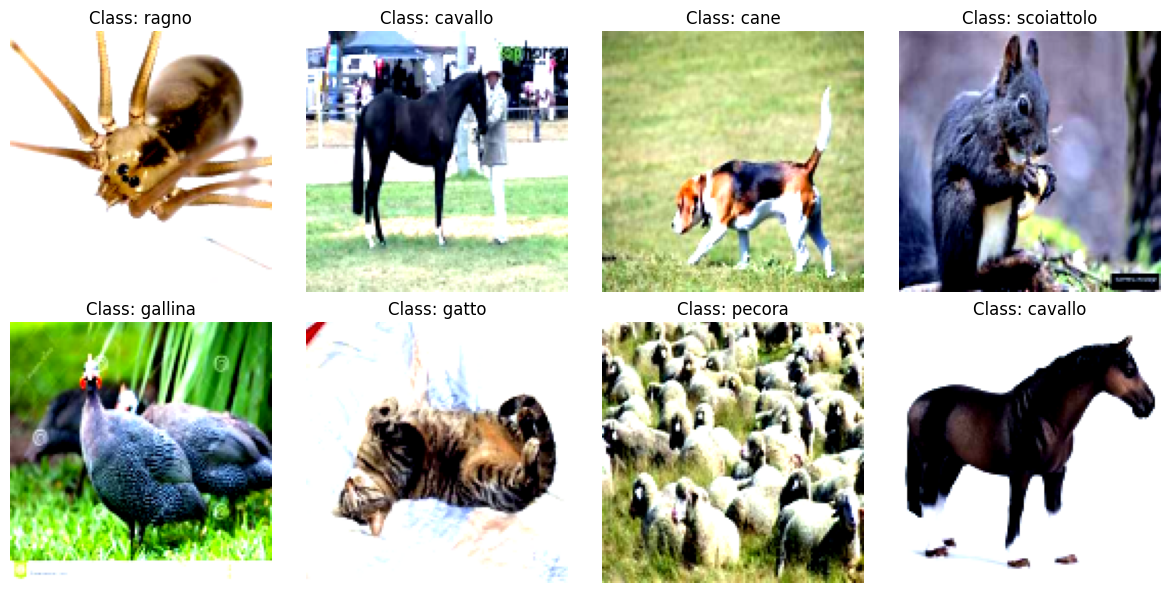

In [8]:
def imshow(img, title):
    """Display an image with title."""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display 8 sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        plt.sca(ax)
        imshow(images[i].cpu(), f"Class: {full_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()

In [9]:
# Create model (FROM SCRATCH - NO PRETRAINED WEIGHTS)
model = VGG16FromScratch(num_classes=10).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🔧 Model Architecture: VGG16 (From Scratch)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Training approach: All layers trained from random initialization")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")


🔧 Model Architecture: VGG16 (From Scratch)
Total parameters: 65,103,946
Trainable parameters: 65,103,946
Training approach: All layers trained from random initialization
Image size: 128x128


## 10. Training Functions

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

print("Training functions defined!")

Training functions defined!


## 11. Training Configuration and Main Training Loop

In [11]:
# Hyperparameters
EPOCHS = 15  # More epochs needed for training from scratch
LEARNING_RATE = 0.01  # Higher learning rate for scratch training

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Optimizer: SGD (momentum=0.9)")
print(f"Scheduler: CosineAnnealingLR")
print(f"Target: 50-70% accuracy (training from scratch)")
print("=" * 60)
# For tracking metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print("\n🚀 Starting Training...")
print("=" * 60)
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print("-" * 60)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'vgg16_scratch_best.pth')
        print(f"✓ Best model saved! Val Acc: {val_acc:.2f}%")

total_time = time.time() - start_time

print(f"\n✅ Training Complete!")
print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

TRAINING CONFIGURATION
Epochs: 15
Batch Size: 64
Learning Rate: 0.01
Optimizer: SGD (momentum=0.9)
Scheduler: CosineAnnealingLR
Target: 50-70% accuracy (training from scratch)

🚀 Starting Training...

Epoch [1/15]


Validation: 100%|██████████| 62/62 [06:38<00:00,  6.43s/it]


Train Loss: 2.0044 | Train Acc: 30.94%
Val Loss: 1.6066 | Val Acc: 46.46%
------------------------------------------------------------
✓ Best model saved! Val Acc: 46.46%

Epoch [2/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.01it/s]


Train Loss: 1.4644 | Train Acc: 50.33%
Val Loss: 1.5256 | Val Acc: 48.45%
------------------------------------------------------------
✓ Best model saved! Val Acc: 48.45%

Epoch [3/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]


Train Loss: 1.2379 | Train Acc: 58.16%
Val Loss: 1.2402 | Val Acc: 57.82%
------------------------------------------------------------
✓ Best model saved! Val Acc: 57.82%

Epoch [4/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.23it/s]


Train Loss: 1.0794 | Train Acc: 63.27%
Val Loss: 1.1417 | Val Acc: 61.49%
------------------------------------------------------------
✓ Best model saved! Val Acc: 61.49%

Epoch [5/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.14it/s]


Train Loss: 0.9249 | Train Acc: 69.15%
Val Loss: 1.1436 | Val Acc: 61.51%
------------------------------------------------------------
✓ Best model saved! Val Acc: 61.51%

Epoch [6/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  7.94it/s]


Train Loss: 0.7783 | Train Acc: 73.95%
Val Loss: 0.9729 | Val Acc: 69.36%
------------------------------------------------------------
✓ Best model saved! Val Acc: 69.36%

Epoch [7/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]


Train Loss: 0.6656 | Train Acc: 77.68%
Val Loss: 0.8147 | Val Acc: 74.20%
------------------------------------------------------------
✓ Best model saved! Val Acc: 74.20%

Epoch [8/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]


Train Loss: 0.5468 | Train Acc: 81.55%
Val Loss: 0.7951 | Val Acc: 73.59%
------------------------------------------------------------

Epoch [9/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  7.81it/s]


Train Loss: 0.4120 | Train Acc: 86.22%
Val Loss: 0.7220 | Val Acc: 77.71%
------------------------------------------------------------
✓ Best model saved! Val Acc: 77.71%

Epoch [10/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.04it/s]


Train Loss: 0.2967 | Train Acc: 90.10%
Val Loss: 0.7342 | Val Acc: 78.35%
------------------------------------------------------------
✓ Best model saved! Val Acc: 78.35%

Epoch [11/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]


Train Loss: 0.1975 | Train Acc: 93.62%
Val Loss: 0.8163 | Val Acc: 77.64%
------------------------------------------------------------

Epoch [12/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  8.22it/s]


Train Loss: 0.1151 | Train Acc: 96.28%
Val Loss: 0.7480 | Val Acc: 82.12%
------------------------------------------------------------
✓ Best model saved! Val Acc: 82.12%

Epoch [13/15]


Validation: 100%|██████████| 62/62 [00:08<00:00,  7.70it/s]


Train Loss: 0.0611 | Train Acc: 98.14%
Val Loss: 0.7148 | Val Acc: 82.37%
------------------------------------------------------------
✓ Best model saved! Val Acc: 82.37%

Epoch [14/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  7.89it/s]


Train Loss: 0.0345 | Train Acc: 99.02%
Val Loss: 0.7140 | Val Acc: 83.16%
------------------------------------------------------------
✓ Best model saved! Val Acc: 83.16%

Epoch [15/15]


Validation: 100%|██████████| 62/62 [00:07<00:00,  7.99it/s]

Train Loss: 0.0246 | Train Acc: 99.43%
Val Loss: 0.7177 | Val Acc: 82.93%
------------------------------------------------------------

✅ Training Complete!
Total training time: 2807.34 seconds (46.79 minutes)
Best validation accuracy: 83.16%


## 12. Plot Training History

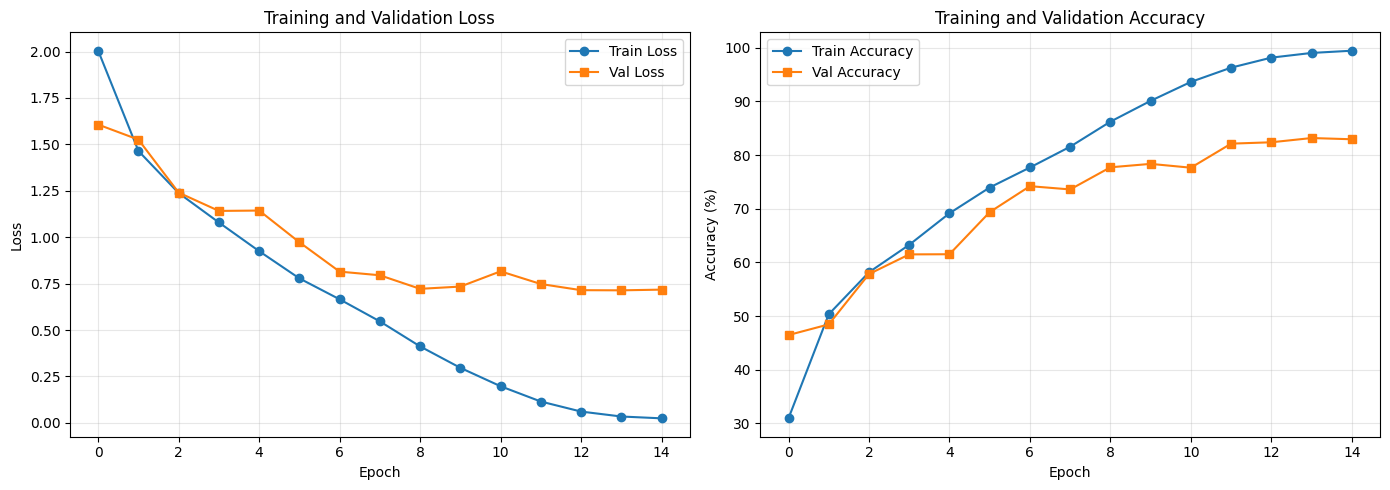

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vgg16_scratch_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


## 13. Test Model

In [13]:
def test_model(model, test_loader):
    """Test the model and return predictions."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    return all_preds, all_labels, test_acc

print("🧪 Testing Model...")
predictions, true_labels, test_accuracy = test_model(model, test_loader)
print(f"\n📊 Test Accuracy: {test_accuracy:.2f}%")

🧪 Testing Model...


Testing: 100%|██████████| 62/62 [06:35<00:00,  6.37s/it]


📊 Test Accuracy: 85.06%


## 14. Confusion Matrix

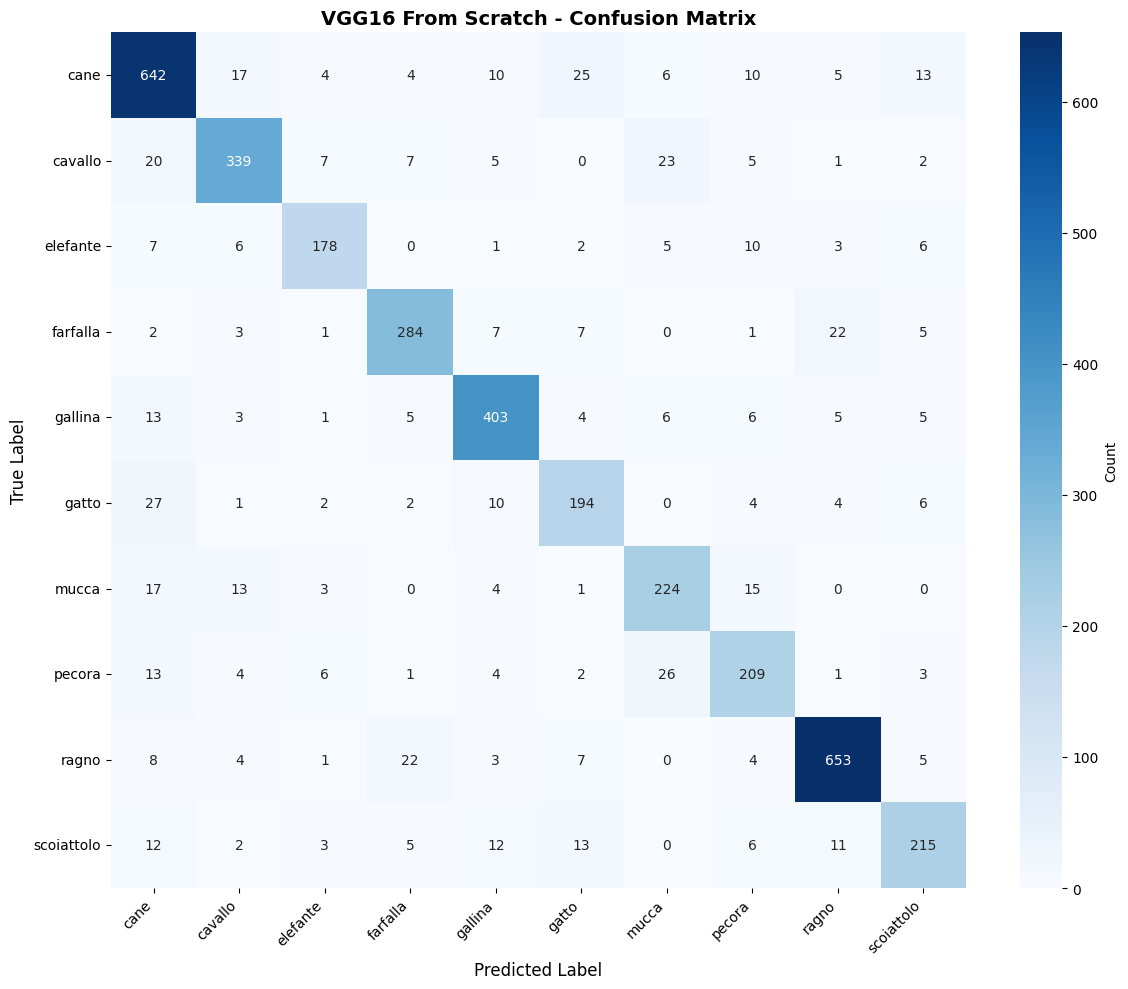


🔍 Most Confused Classes:
  cane → cavallo: 17 times
  cane → gallina: 10 times
  cane → gatto: 25 times
  cane → mucca: 6 times
  cane → pecora: 10 times
  cane → scoiattolo: 13 times
  cavallo → cane: 20 times
  cavallo → elefante: 7 times
  cavallo → farfalla: 7 times
  cavallo → mucca: 23 times
  elefante → cane: 7 times
  elefante → cavallo: 6 times
  elefante → pecora: 10 times
  elefante → scoiattolo: 6 times
  farfalla → gallina: 7 times
  farfalla → gatto: 7 times
  farfalla → ragno: 22 times
  gallina → cane: 13 times
  gallina → mucca: 6 times
  gallina → pecora: 6 times
  gatto → cane: 27 times
  gatto → gallina: 10 times
  gatto → scoiattolo: 6 times
  mucca → cane: 17 times
  mucca → cavallo: 13 times
  mucca → pecora: 15 times
  pecora → cane: 13 times
  pecora → elefante: 6 times
  pecora → mucca: 26 times
  ragno → cane: 8 times
  ragno → farfalla: 22 times
  ragno → gatto: 7 times
  scoiattolo → cane: 12 times
  scoiattolo → gallina: 12 times
  scoiattolo → gatto: 13 

In [14]:
class_names = full_dataset.classes
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('VGG16 From Scratch - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('vgg16_scratch_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify most confused pairs
print("\n🔍 Most Confused Classes:")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 5:
            print(f"  {class_names[i]} → {class_names[j]}: {cm[i][j]} times")

## 15. Classification Report

In [15]:
print("\n📋 Classification Report:")
print("=" * 70)
report = classification_report(true_labels, predictions,
                                target_names=class_names,
                                digits=3)
print(report)

# Save report
with open('vgg16_scratch_classification_report.txt', 'w') as f:
    f.write(report)


📋 Classification Report:
              precision    recall  f1-score   support

        cane      0.844     0.872     0.858       736
     cavallo      0.865     0.829     0.846       409
    elefante      0.864     0.817     0.840       218
    farfalla      0.861     0.855     0.858       332
     gallina      0.878     0.894     0.886       451
       gatto      0.761     0.776     0.768       250
       mucca      0.772     0.809     0.790       277
      pecora      0.774     0.777     0.776       269
       ragno      0.926     0.924     0.925       707
  scoiattolo      0.827     0.771     0.798       279

    accuracy                          0.851      3928
   macro avg      0.837     0.832     0.834      3928
weighted avg      0.851     0.851     0.851      3928



## 16. Per-Class Accuracy Visualization

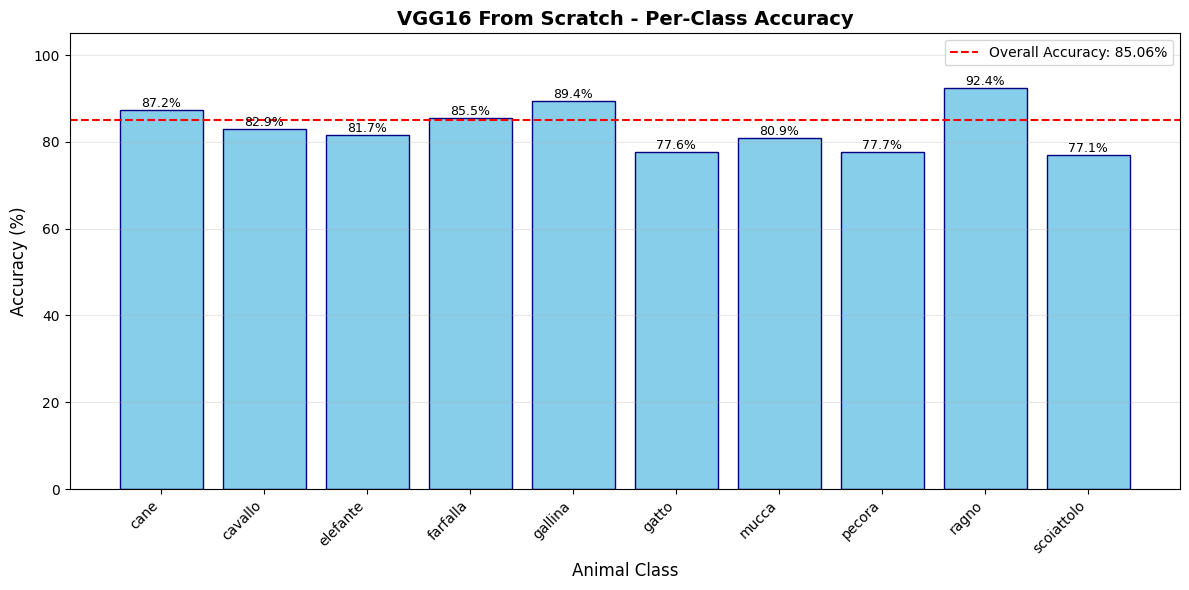

In [16]:
# Calculate per-class accuracy
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for pred, true in zip(predictions, true_labels):
    class_total[true] += 1
    if pred == true:
        class_correct[true] += 1

class_accuracy = [100 * c / t if t > 0 else 0
                  for c, t in zip(class_correct, class_total)]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='navy')
plt.axhline(y=test_accuracy, color='r', linestyle='--',
            label=f'Overall Accuracy: {test_accuracy:.2f}%')
plt.xlabel('Animal Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('VGG16 From Scratch - Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('vgg16_scratch_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


## 17. Save Model and Results

In [17]:
print(f"\n" + "=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)
print(f"Model: VGG16 (From Scratch - No Transfer Learning)")
print(f"Dataset: Animals10 ({len(full_dataset)} images)")
print(f"Classes: {len(class_names)}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Optimizer: SGD (momentum=0.9)")
print(f"\nResults:")
print(f"  Test Accuracy: {test_accuracy:.2f}%")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Total Training Time: {total_time/60:.2f} minutes")
print(f"\nTotal Parameters: {total_params:,}")
print(f"All parameters trained from random initialization")
print("=" * 70)

# Save model
torch.save(model.state_dict(), 'vgg16_scratch_final.pth')
print("\n✅ Model saved: vgg16_scratch_final.pth")


FINAL RESULTS SUMMARY
Model: VGG16 (From Scratch - No Transfer Learning)
Dataset: Animals10 (26179 images)
Classes: 10
Image Size: 128x128

Training Configuration:
  Epochs: 15
  Batch Size: 64
  Learning Rate: 0.01
  Optimizer: SGD (momentum=0.9)

Results:
  Test Accuracy: 85.06%
  Best Validation Accuracy: 83.16%
  Total Training Time: 46.79 minutes

Total Parameters: 65,103,946
All parameters trained from random initialization

✅ Model saved: vgg16_scratch_final.pth
